
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-2-Questions/blob/main/HW2_P2_DQN_vs_DDQN.ipynb) [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/DeepRLCourse/Homework-2-Questions/blob/main/HW2_P2_DQN_vs_DDQN.ipynb)

# **HW2: DQN vs DDQN**
---


> - Full Name: **Payam Taebi**
> - Student ID: **400104867**

## **Overview**

DQN, introduced in 2013, revolutionized deep reinforcement learning.  
In this notebook, you'll use PyTorch to train a Deep Q-Learning (DQN) agent on the [Cart-Pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) task from [Gymnasium](https://gymnasium.farama.org/). You'll also implement Double DQN (DDQN), an improved version with better stability, convergence, and test performance.

### In this notebook:
- Explore the Cart-Pole environment and observe an untrained agent.
- Set up a Gymnasium environment.
- Implement and train DQN and DDQN from scratch.
- Compare their performance to understand strengths and weaknesses.
- Render the trained agent’s behavior.

Before starting, import the necessary packages. Helper functions are provided for visualization and rendering.


## **Setup**  

First, install the required packages. If you're using Colab, everything should work smoothly. However, on a local system, you may encounter some dependency installation challenges.  


In [1]:
!sudo apt-get update --quiet
!pip install imageio --quiet
!sudo apt-get install -y xvfb ffmpeg --quiet
!pip install swig --quiet
!pip install gymnasium[box2d]

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,321 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,533 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,956 kB]
Get:13 http://archive.ubu

In [2]:
import gymnasium as gym
import random
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from collections import namedtuple, deque

import base64
import json
import imageio
import IPython

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## **Helper Functions**  
This section contains functions for visualizing your results.  


In [3]:
# @title helper functions

# disable warnings
import logging
logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)


def plot_rewards(sum_of_rewards,i,show_result=False):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title(f'Training the Agent number {i}')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def plot_smooth(DDQN_mean_rewards,DDQN_min_rewards,DDQN_max_rewards,DQN_mean_rewards,DQN_min_rewards,DQN_max_rewards):
      plt.figure(figsize=(12,7))

      # Plot DDQN
      DDQN, = plt.plot(range(len(DDQN_mean_rewards)), DDQN_mean_rewards, color='blue', label='DDQN')
      plt.fill_between(range(len(DDQN_min_rewards)), DDQN_min_rewards, DDQN_max_rewards, color='blue', alpha=0.2)

      # Plot DQN
      DQN, = plt.plot(range(len(DQN_mean_rewards)), DQN_mean_rewards, color='red', label='DQN')
      plt.fill_between(range(len(DQN_min_rewards)), DQN_min_rewards, DQN_max_rewards, color='red', alpha=0.2)

      # Fix legend
      plt.legend(handles=[DDQN, DQN])
      plt.show()



def plot_values(values):
    plt.figure(figsize=(15, 9))

    # Iterate over each value set
    for i, value in enumerate(values):
        for n, Data in enumerate(value):
            plt.plot(range(len(Data)), Data, label=f"Values of selected trained Agent Number {i+1}, Evaluation {n+1}")

    plt.title('Test Episode Mean Q values')
    plt.xlabel("Episodes")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.show()



def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def create_policy_eval_video(env, agent, filename, num_episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                state = torch.from_numpy(state).unsqueeze(0).to(device)
                action,_ = agent.act(state, greedy=True)
                state, reward, terminated, truncated, info = env.step(action)
                video.append_data(env.render())
                if terminated or truncated:
                    break
    return embed_mp4(filename)


def save_progress(sum_of_rewards, PATH):
    # Convert the list to a JSON string
    json_data = json.dumps(sum_of_rewards)
    # Write the JSON data to a file
    with open(PATH + str('.json'), "w") as file:
        file.write(json_data)


def load_progress(PATH):
    with open(PATH + str('.json'), "r") as file:
        json_data = file.read()
    # Load the JSON data back into a Python list
    return json.loads(json_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Explore the Environment (5 points)**

Let's explore the Gym Cart-Pole environment.  
First, we need to create the environment and set `rgb_array` as the render mode for visualization.  


In [4]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
# Print the observation space and action space
print('Observations:', env.observation_space)
print('Actions:', env.action_space)


Observations: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Actions: Discrete(2)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Complete the following class to create an agent that selects actions randomly from the action space.  


In [5]:
class RandomAgent():
    def __init__(self, env_name, mode='rgb_array'):
        self.env = gym.make(env_name, render_mode=mode)

    def act(self, state=None, greedy=None):
        # Select and return a random action
        action = self.env.action_space.sample()
        return action, 0


**Monitor the random Agent perfomance**

In [6]:
random_agent = RandomAgent("CartPole-v1")
create_policy_eval_video(random_agent.env, random_agent, 'random_policy', num_episodes=5)

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

## **Main Components of DDQN and Its Variants**  

### **Deep Q Network (DQN)**  

DQN uses a neural network to estimate $Q(s,a)$ values. In theory, the network takes both state and action as input and outputs a single $Q(s,a)$ value. However, in practice, it takes only the state as input and outputs a vector of Q-values, where each value corresponds to an action in the action space.  

<img src="figs/network.jpg" style="margin-left: 300px;">  

Now, let's define the Deep Q Network.  


In [7]:

class QNetwork(nn.Module):

  def __init__(self, state_size, action_size):

      super(QNetwork, self).__init__()

      self.relu = nn.ReLU()
      self.fc1 = nn.Linear(state_size, 512)
      self.fc2 = nn.Linear(512,125)
      self.fc3 = nn.Linear(125,action_size)


  def forward(self, state):

    x = self.relu(self.fc1(state))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))

    return x



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Experience Replay Buffer**  

To train the network, we need data. We store **transitions**—tuples of (state, action, reward, next state, termination)—in a replay buffer for later sampling.  

- **state (s):** The current situation the agent is experiencing.  
- **action (a):** The action taken by the agent.  
- **next state (s'):** The new state after taking the action.  
- **reward (r):** The feedback received for the action.  
- **termination (done):** A boolean indicating if the episode has ended.  

These transitions are stored in the **Experience Replay Buffer**, allowing us to sample and train the Q-network efficiently.  not using replay buffer would make the learing highly unstable and inefficient.

A stack of transitions $(s, a, s', r, done)$ looks like this:  

<img src="figs/buffer.png" style="margin-left: 300px;">  

**We shuffle the sampled data to break temporal correlations before training.**  

Now, let's define the Experience Replay Buffer class.  


## **Experience Replay Buffer**  

- `push`: Stores transitions from the environment.  
- `sample`: Shuffles and samples transitions.  
- `__len__` Returns the number of stored transitions.  
- `get_size`: Returns the buffer size  `__len__` as an output.  


In [8]:
class ReplayMemory(object):

    def __init__(self, capacity, batch_size):
        self.memory = deque([],maxlen = capacity)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names = ("state", "action", "reward", "next_state", "done"))

    def push(self, state, action, reward, next_state, done):
            e = self.experience(state, action, reward, next_state, done)
            self.memory.append(e)

    def sample(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        experiences = random.sample(self.memory, k=batch_size)
        
        def to_numpy(x):
            # If x is a torch tensor, move it to CPU and convert to numpy array
            return x.cpu().detach().numpy() if isinstance(x, torch.Tensor) else x
    
        states = np.vstack([to_numpy(e.state) for e in experiences if e is not None])
        actions = np.vstack([to_numpy(e.action) for e in experiences if e is not None])
        rewards = np.vstack([to_numpy(e.reward) for e in experiences if e is not None])
        next_states = np.vstack([to_numpy(e.next_state) for e in experiences if e is not None])
        dones = np.vstack([to_numpy(e.done) for e in experiences if e is not None]).astype(np.uint8)
        
        return states, actions, rewards, next_states, dones

    def __len__(self):
              return len(self.memory)

    def get_size(self):
        return self.__len__()

## **DQN Agent**  

DQN, the first Deep RL algorithm, uses TD learning similar to Q-learning, aiming to minimize the distance:  

$r_i + \gamma \cdot max_{a'} Q_\theta'(s_i',a_i') - Q_\theta(s_i,a_i)$  

The more appropriate cost function is:  

$[r_i + \gamma \cdot max_{a'} Q_\theta(s_i',a_i') - Q_\theta(s_i,a_i)]^2$  $(1)$  

Instead of a tabular method, DQNs use deep networks to estimate Q-values.  

In this class, we implement the original DQN with an experience replay buffer. The training process is as follows:  

**Network Updating**  

1. Gather data. Once the buffer reaches a certain size, start training the Q-networks.  
2. Sample transitions and feed the States (instead of State-action pairs) to the Q-network to estimate $Q_\theta(s_i,a_i)$.  
3. Feed Next_States to the Q-network to estimate $Q_\theta(s_i',a_i')$.  
4. Use the average of equation $(1)$ to update the network via backpropagation.  


## **$\epsilon-\text{greedy policy}$**  

Exploration is crucial in RL algorithms. In DQN, exploration is achieved using the $\epsilon-\text{greedy policy}$.

$$
\pi(a \mid s) =
\begin{cases}
\arg\max\limits_{a} Q(s, a), & \text{with probability } 1 - \epsilon, \\
\text{random action}, & \text{with probability } \epsilon.
\end{cases}
$$


With probability $\epsilon$, a random action is chosen for exploration, and with probability $1 - \epsilon$, the best action is selected for exploitation.  

$\epsilon$ starts high and gradually decreases over time. The decay follows this formula:

$$\varepsilon = \varepsilon_{end} + \left(\varepsilon_{start} - \varepsilon_{end}\right)\exp\left(-\frac{\text{steps done}}{\text{decay rate}}\right)$$  

**The $\epsilon-\text{greedy policy}$ is used in both DQN and DDQN.**  

## **Original DQN Pseudocode**  

<img src="figs/DQN.png" style="margin-left: 300px;">  

### Properties of the Algorithm:

- Uses a single network to estimate both $Q(s,a)$ and $Q(s',a')$, which can lead to instability—this is the problem DDQN aims to solve. **It's up to you to figure out why this is a problem.**  
- Utilizes the $\epsilon-\text{greedy}$ policy for exploration.

**Hint:**  
- A single network leads to unstable learning, hence the introduction of a target network in modified versions.  
- The $\epsilon-\text{greedy}$ policy can sometimes hinder the learning process, despite addressing the exploration problem.  

## **Implementing DQN class (20 points)**


کلی اینجا سر اینکه تارگت رو نباید میزاشتیم اذیت شدم خیلی بیهوده بود واقعا خب منطقا باید یا نمیومد کلا توی کد یا خب توی لرنینگ طبق کامنتی ک گزاشتم واسه تستش از تارگت پالیسی استفاده بشه

In [9]:
class DQNAgent(object):

    def __init__(self, q_network, memory, optimizer, criterion, params):
        # Create the policy network and send it to the device (GPU if available)
        self.policy_net = q_network.to(device)
        # Use the provided replay buffer instance directly
        self.reply_buffer = memory
        
        # Initialize loss criterion and optimizer with AMSGrad enabled
        self.criterion = criterion()
        self.optimizer = optimizer(self.policy_net.parameters(), lr=params['LR'], amsgrad=True)
    
        # Set hyperparameters
        self.gamma = params['GAMMA']
        self.eps = {
            'START': params['EPS_START'], 
            'END': params['EPS_END'], 
            'DECAY': params['EPS_DECAY']
        }
        self.steps_done = 0
        self.Loss = []

    def step(self, state, action, reward, next_state, done):
        # Increment the steps count
        self.steps_done += 1
        # Save the experience in the replay buffer
        self.reply_buffer.push(state, action, reward, next_state, done)
        
        # Once enough experiences are stored, sample a batch and update the network
        if self.reply_buffer.get_size() > self.reply_buffer.batch_size:
            states, actions, rewards, next_states, dones = self.reply_buffer.sample()
            self.learn(states, actions, rewards, next_states, dones)

    def act(self, state, greedy=False):
        # Calculate the current epsilon threshold using exponential decay
        self.eps_threshold = self.eps['END'] + (self.eps['START'] - self.eps['END']) * np.exp(- self.steps_done / self.eps['DECAY'])

        if greedy or random.random() > self.eps_threshold:
            with torch.no_grad():
                # Ensure state is a torch tensor with the correct shape
                if not isinstance(state, torch.Tensor):
                    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
                # Forward pass through the network to get Q-values and select the best action
                Q_values = self.policy_net(state)
                action = torch.argmax(Q_values, dim=1).item()
                max_Q = Q_values.max().item()
        else:
            # Select a random action (assuming the final layer's output size equals the number of actions)
            action = random.randrange(self.policy_net.fc3.out_features)
            max_Q = 0
        return action, max_Q

    def learn(self, states, actions, rewards, next_states, dones):
        # Convert the batch data from numpy arrays to torch tensors and move to the device
        states = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(actions).long().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        next_states = torch.from_numpy(next_states).float().to(device)
        dones = torch.from_numpy(dones).float().to(device)
        
        # Compute predicted Q-values for the taken actions using the policy network
        state_Q = self.policy_net(states).gather(1, actions)
        
        with torch.no_grad():
            # For standard DQN, use the same network to compute Q-values for next states
            next_state_Q = self.policy_net(next_states).max(1)[0].unsqueeze(1)
            # Compute the Bellman backup target: r + γ * max(Q_next) * (1 - done)
            target = rewards + (self.gamma * next_state_Q * (1 - dones))
        
        # Compute loss and update the network via backpropagation
        loss = self.criterion(state_Q, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.Loss.append(loss.item())

    def save(self, PATH):
        torch.save(self.policy_net, PATH + '_policy.pt')

    def load(self, PATH):
        self.policy_net = torch.load(PATH + '_policy.pt')


# **Training the DQN Agents**

Now that you've implemented DQN and explored the Gym CartPole environment, it's time to train an actual agent.  

**First, we train the DQN agent.**  


## **Setting Up Essentials for DQN (5 points)**  

- **CartPole Environment Setup**  
- **Hyperparameter Initialization**  
- **Creating DQN Agents with Different Random Seeds**  
  - Why? Training multiple agents with different seeds helps assess DQN's consistency and robustness.  
  - We use **5 random seeds** for better evaluation.  
- **Defining Optimizer and Loss Function**  


In [10]:
def create_dqn_agent(seed, QNetwork, ReplayMemory, optimizer, criterion, params):
    # Set random seeds for reproducibility
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Instantiate the Q-network using the global n_observations and n_actions
    q_net = QNetwork(n_observations, n_actions).to(device)

    # Create the replay memory with specified capacity and batch size
    memory = ReplayMemory(capacity=params['BUFFER_SIZE'], batch_size=params['BATCH_SIZE'])

    # Instantiate and return the DQNAgent using the q-network, replay memory, optimizer, and criterion
    return DQNAgent(q_net, memory, optimizer, criterion, params)


# Define hyperparameters for training the agent
params = {
    'BUFFER_SIZE': 10000,      # Size of the replay buffer
    'BATCH_SIZE': 128,          # Number of experiences sampled per learning step
    'GAMMA': 0.99,             # Discount factor for future rewards
    'EPS_START': 0.9,          # Starting value for epsilon (exploration)
    'EPS_END': 0.05,           # Final value for epsilon
    'EPS_DECAY': 1000,         # Decay rate for epsilon to allow prolonged exploration
    'LR': 1e-4                  # Learning rate for the optimizer
}

# Setting different seed values for evaluating agent robustness
seeds = [1, 10, 15, 43, 63]

# Setup the CartPole Environment and reset it
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, info = env.reset()

# Get number of actions from the gym action space (CartPole has 2 actions)
n_actions = env.action_space.n

# Get the number of state observations (CartPole has 4 observations)
n_observations = env.observation_space.shape[0]

# Choose the optimizer and loss function
optimizer = optim.Adam        # Using Adam optimizer
criterion = nn.MSELoss        # Mean Squared Error Loss

# Initialize the agent list and the sum of rewards list for each agent
DQN_agents = []
dqn_sum_of_rewards = []

# Create multiple DQN agents with different seeds
for seed in seeds:
    dqn_agent = create_dqn_agent(seed, QNetwork, ReplayMemory, optimizer, criterion, params)
    DQN_agents.append(dqn_agent)
    dqn_sum_of_rewards.append([])


## **Training Loop for the DQN Agent (10 points)**  

With the hyperparameters set, we can now train the agent.  

The code is designed for convenient retraining. simply re-run the segment to continue training if the agent hasn’t achieved satisfactory results.  


In [11]:
# Set the number of training episodes
num_episodes = 2000

for i, dqn_agent in enumerate(DQN_agents):
    for e in range(1, num_episodes + 1):
        # Reset the environment for a new episode
        state, info = env.reset()
        episode_reward = 0

        while True:
            # Select an action using the ε–greedy policy (non-greedy during training)
            action, _ = dqn_agent.act(state, greedy=False)
            # Execute the action in the environment
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Save the transition and update the network using the agent's step function
            dqn_agent.step(state, action, reward, next_state, done)

            episode_reward += reward
            state = next_state

            # Break the loop if the episode has ended
            if done:
                break

        # Record the total reward for this episode
        dqn_sum_of_rewards[i].append(episode_reward)

        # Save the model and training progress every 50 episodes
        if e % 50 == 0:
            plot_rewards(dqn_sum_of_rewards[i], i)
            path = f'DQN_{i}_Network' + str(len(dqn_sum_of_rewards[i])).zfill(4)
            dqn_agent.save(path)
            save_progress(dqn_sum_of_rewards[i], path)


<Figure size 1200x600 with 0 Axes>

## **Why DDQN?**  

DQN and its variants use a replay buffer and Q-network, but DQN struggles with learning stability. **Can you identify why?**  
To address this, we introduce DDQN—a modified version with improved stability, capable of handling more complex environments.  

---

## **DDQN Agent**  

### **Deep Q-Networks in DDQN**  

DDQN uses two networks:  

- **Online Network**: Estimates $Q_\theta(s_i,a_i)$, representing the value of a state-action pair.  its parameters is denoted with $\theta$
- **Target Network**: Estimates $Q_{\theta'}(s_i',a_i')$, representing the value of the next state-action pair.  its parameters is denoted with $\theta'$

Both networks have identical architectures but serve different roles. The target network helps stabilize training by reducing overestimation bias.  

### **Network Updating**  

In DQN, a single network estimates both $Q(s_i,a_i)$ and $Q(s_i',a_i')$, leading to instability. DDQN introduces a key change:  

- The **online network** selects the best action:  
  $$ \arg\max_a Q_\theta(s'_i,a) $$
- The **target network** estimates its value:  
  $$ Q_{\theta'}(s_i, \arg\max_a Q_\theta(s'_i,a)) $$  

This modifies the loss function to:  

$$ [r_i + \gamma \cdot Q_{\theta'}(s_i, \arg\max_a Q_\theta(s'_i,a)) - Q_\theta(s_i,a_i)]^2 $$  

In this version DDQN, we also use $\text{soft replacemet}$ which is not a part of original DDQN, that another modification that is applied.
*   `soft_update` : The target network is updated at every step with a soft update controlled by the hyperparameter $\tau$, which was previously defined. The target is updated according to: $$\theta' \leftarrow \tau \theta + (1 - \tau) \theta'$$

## DDQN Psudocode

<img src="figs/DDQN.png" style="margin-left: 300px;">  


Now, let's define the **DDQN class**.  



## **Impelementing DDQN Class (20 points)**

In [12]:
import copy

class DDQNAgent(object):

    def __init__(self, q_network, memory, optimizer, criterion, params):
        # Create policy and target networks based on the provided q_network instance
        self.policy_net = q_network.to(device)
        self.target_net = copy.deepcopy(q_network).to(device)
        self.target_net.eval()

        # Use the already instantiated replay buffer directly
        self.reply_buffer = memory

        # Initialize the loss criterion and the optimizer with AMSGrad enabled
        self.criterion = criterion()
        self.optimizer = optimizer(self.policy_net.parameters(), lr=params['LR'], amsgrad=True)

        # Hyperparameters
        self.tau = params['TAU']               # Soft update factor
        self.gamma = params['GAMMA']           # Discount factor
        self.update_rate = params['UPDATE_RATE']  # Frequency of soft update steps
        self.eps = {'START': params['EPS_START'], 'END': params['EPS_END'], 'DECAY': params['EPS_DECAY']}
        self.steps_done = 0
        self.Loss = []

        # Initialize target network weights to be equal to the policy network weights
        self.soft_update(1.0)


    def step(self, state, action, reward, next_state, done):
        # Increment steps done
        self.steps_done += 1

        # Save the experience in the agent's replay buffer
        self.reply_buffer.push(state, action, reward, next_state, done)

        # If enough experiences are stored, sample a batch and perform a learning step
        if self.reply_buffer.get_size() > self.reply_buffer.batch_size:
            states, actions, rewards, next_states, dones = self.reply_buffer.sample()
            self.learn(states, actions, rewards, next_states, dones)

    def act(self, state, greedy=False, eps_threshold=None):
        # Compute the current epsilon threshold using exponential decay
        self.eps_threshold = self.eps['END'] + (self.eps['START'] - self.eps['END']) * np.exp(-self.steps_done / self.eps['DECAY'])

        if greedy or random.random() > self.eps_threshold:
            with torch.no_grad():
                # Ensure state is a torch tensor with correct shape
                if not isinstance(state, torch.Tensor):
                    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
                # Get Q-values from the policy network and select the greedy action
                Q_values = self.policy_net(state)
                action = torch.argmax(Q_values, dim=1).item()
                max_Q = Q_values.max().item()
        else:
            # Select a random action
            # Here we assume the final layer's output size equals the number of actions.
            # Alternatively, you might store the number of actions as a parameter.
            action = random.randrange(self.policy_net.fc3.out_features)
            max_Q = 0
        return action, max_Q

    def learn(self, states, actions, rewards, next_states, dones):
        # Convert batch data from NumPy arrays to torch tensors and move to device
        states = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(actions).long().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        next_states = torch.from_numpy(next_states).float().to(device)
        dones = torch.from_numpy(dones).float().to(device)

        # Compute the predicted Q-values using the policy network for the actions taken
        # Using .gather to select Q(s, a) for each sample
        state_Q = self.policy_net(states).gather(1, actions)

        with torch.no_grad():
            # Use the online network (policy_net) to select the best next action for each next state
            best_next_actions = self.policy_net(next_states).argmax(1).unsqueeze(1)
            # Use the target network to evaluate the Q-value of these best next actions
            next_state_Q = self.target_net(next_states).gather(1, best_next_actions)
            # Compute the TD target: r + γ * Q(next_state, best_next_action) * (1 - done)
            target = rewards + (self.gamma * next_state_Q * (1 - dones))

        # Compute the loss between predicted Q-values and the TD target
        loss = self.criterion(state_Q, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.Loss.append(loss.item())

        # Soft update the target network every update_rate steps
        if self.steps_done % self.update_rate == 0:
            self.soft_update(self.tau)

    def soft_update(self, tau):
        # Soft update of target network weights: θ′ = τ*θ + (1-τ)*θ′
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(tau * policy_param.data + (1.0 - tau) * target_param.data)

    def save(self, PATH):
        torch.save(self.policy_net, PATH + '_policy.pt')
        torch.save(self.target_net, PATH + '_target.pt')

    def load(self, PATH):
        self.policy_net = torch.load(PATH + '_policy.pt')
        self.target_net = torch.load(PATH + '_target.pt')


## **Setting Up Essentials for DDQN (5 points)**  

- **CartPole Environment Setup**  
- **Hyperparameter Initialization**  
- **Creating DDQN Agents with Different Random Seeds**  
  - Why? Training multiple agents with different seeds helps assess DDQN's consistency and robustness.  
  - We use **5 random seeds** for better evaluation.  
- **Defining Optimizer and Loss Function**  


In [13]:
def create_ddqn_agent(seed, QNetwork, ReplayMemory, optimizer, criterion, params):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    # Instantiate the Q-network using the global n_observations and n_actions
    q_net = QNetwork(n_observations, n_actions).to(device)
    # Instantiate the replay memory with the provided buffer size and batch size
    memory = ReplayMemory(params['BUFFER_SIZE'], params['BATCH_SIZE'])
    # Instantiate and return the DDQNAgent using the q_network, replay memory, optimizer, and criterion
    return DDQNAgent(q_net, memory, optimizer, criterion, params)


params = {
    'UPDATE_RATE': 4,        # Frequency (in steps) to perform soft update of the target network
    'BUFFER_SIZE': 5000,      # Size of the replay buffer
    'BATCH_SIZE': 32,          # Number of experiences sampled per learning step
    'GAMMA': 0.99,             # Discount factor for future rewards
    'EPS_START': 0.99,          # Starting value for epsilon (exploration)
    'EPS_END': 0.03,           # Final value for epsilon
    'EPS_DECAY': 1000,         # Decay rate for epsilon to allow prolonged exploration
    'TAU': 0.01,              # Soft update factor for target network updates
    'LR': 1e-4                 # Learning rate for the optimizer
}

# Setting different seed values for evaluation
seeds = [1, 10, 15, 43, 63]

# Setup the CartPole Environment and reset it
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, info = env.reset()

# Get number of actions from gym action space
n_actions = env.action_space.n

# Get the number of state observations
n_observations = env.observation_space.shape[0]

# Choose the optimizer and loss function
optimizer = optim.Adam    # Using Adam optimizer
criterion = nn.MSELoss    # Mean Squared Error Loss

# Create multiple DDQN agents with different seeds
agents = []
sum_of_rewards = []
for seed in seeds:
    agent = create_ddqn_agent(seed, QNetwork, ReplayMemory, optimizer, criterion, params)
    agents.append(agent)
    sum_of_rewards.append([])


## **Training Loop for DDQN Agent (10 points)**  

With the hyperparameters set, we can now train the agent. The following code allows for easy re-training—if the agent's performance isn't satisfactory, simply re-run the segment to continue training for more episodes.  


In [14]:
for i, DDQN_agent in enumerate(agents):
    for e in range(1, num_episodes + 1):
        # Reset the environment for a new episode
        state, info = env.reset()
        episode_reward = 0

        while True:
            # Select an action using the agent's epsilon-greedy policy (non-greedy mode for training)
            action, _ = DDQN_agent.act(state, greedy=False)
            # Execute the action in the environment
            next_state, reward, terminated, truncated, info = env.step(action)
            # Determine if the episode has ended
            done = terminated or truncated
            # Save the transition and perform a learning step
            DDQN_agent.step(state, action, reward, next_state, done)

            episode_reward += reward
            state = next_state

            # Break the loop if the episode has ended
            if done:
                break

        # Append the episode's total reward to the reward list for this agent
        sum_of_rewards[i].append(episode_reward)
        # Every 50 episodes, plot the rewards and save the model and progress
        if e % 50 == 0:
            plot_rewards(sum_of_rewards[i], i)
            path = f'DDQN_{i}_Network' + str(len(sum_of_rewards[i])).zfill(4)
            DDQN_agent.save(path)
            save_progress(sum_of_rewards[i], path)


<Figure size 1200x600 with 0 Axes>

##  IN GHABLIA RO NESHOON BEDIM

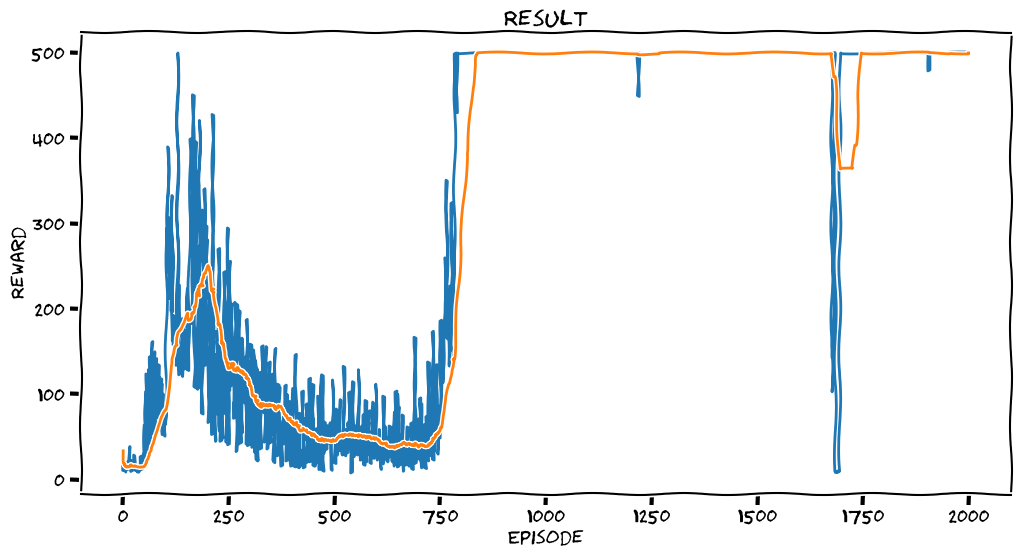

<Figure size 1200x600 with 0 Axes>

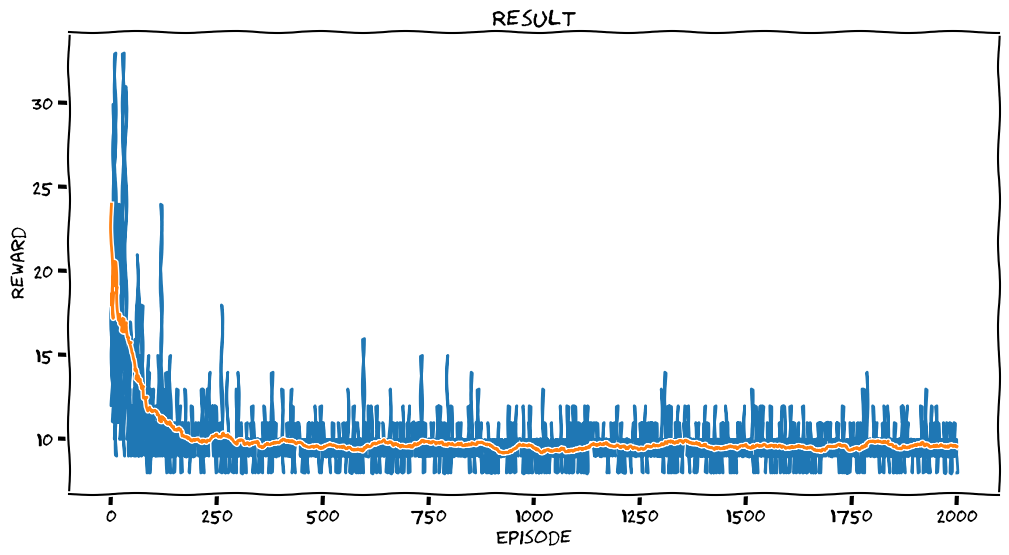

<Figure size 1200x600 with 0 Axes>

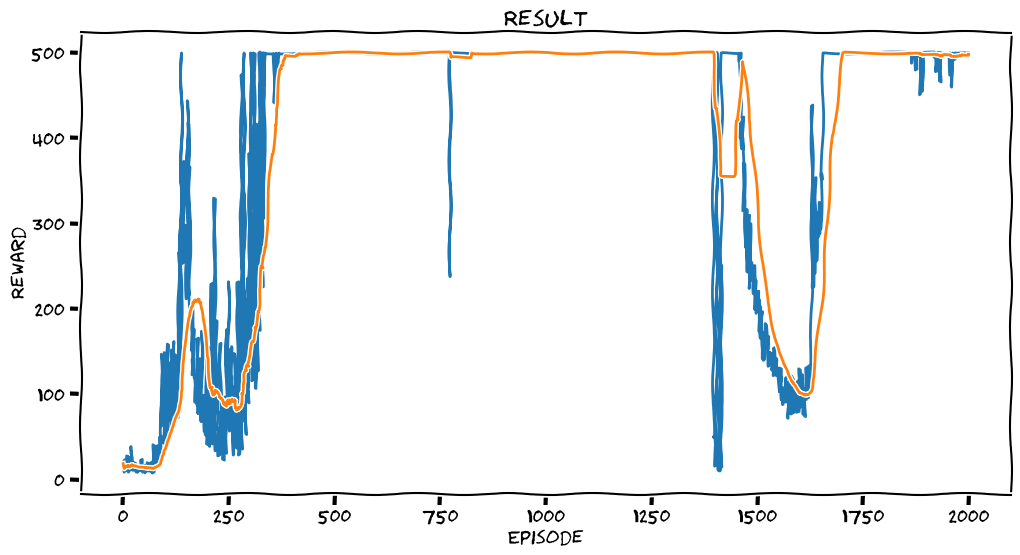

<Figure size 1200x600 with 0 Axes>

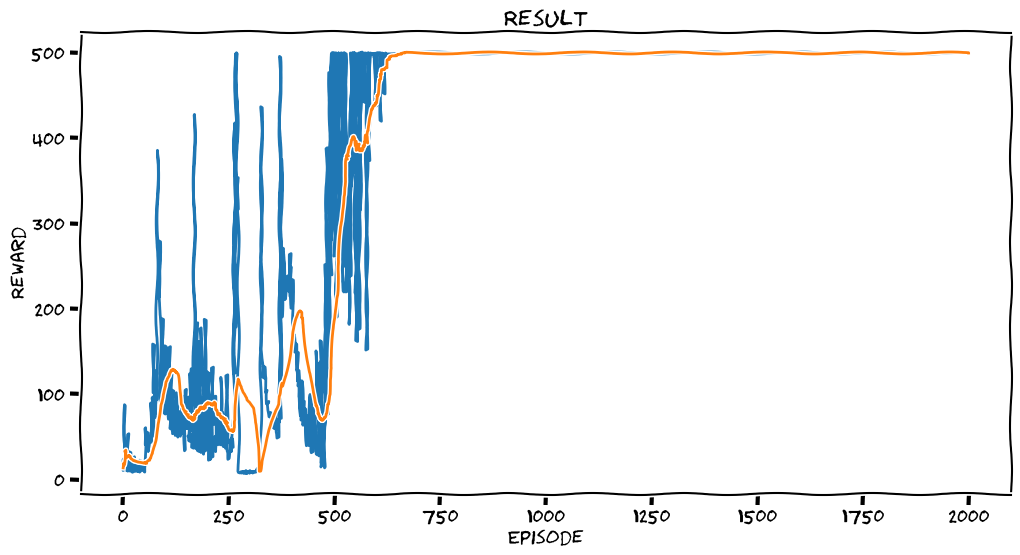

<Figure size 1200x600 with 0 Axes>

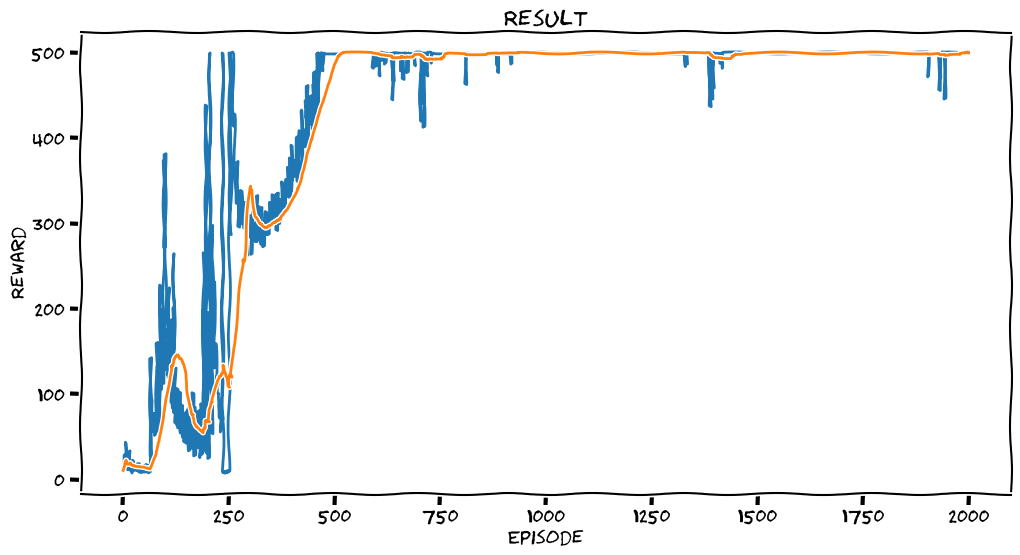

<Figure size 1200x600 with 0 Axes>

++++++++++++++++++++++++++++++++++++++++++++++++++


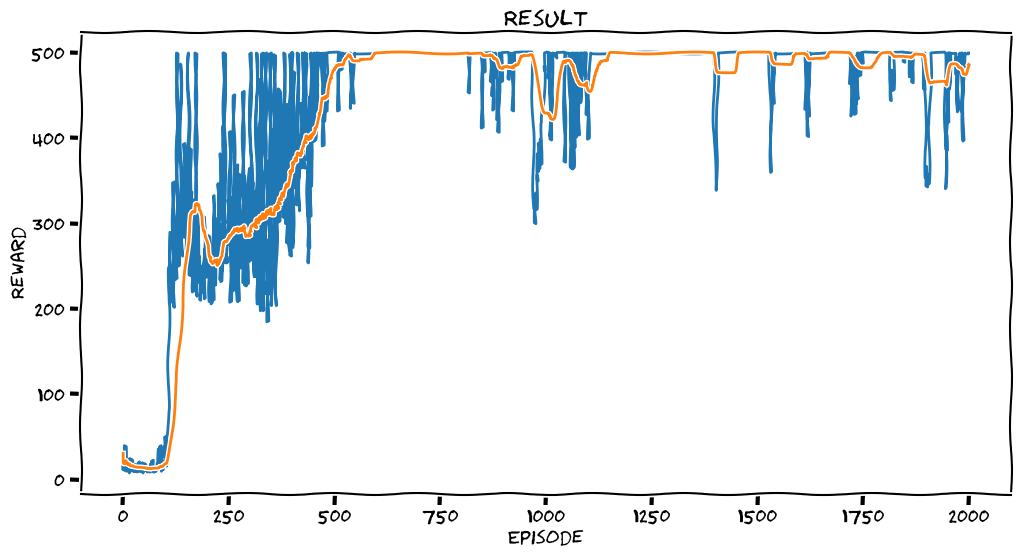

<Figure size 1200x600 with 0 Axes>

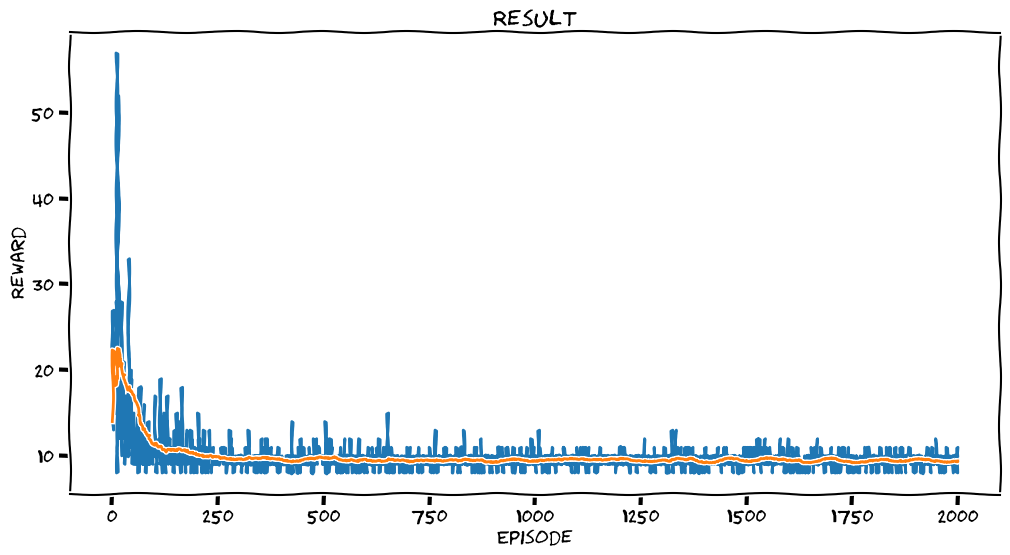

<Figure size 1200x600 with 0 Axes>

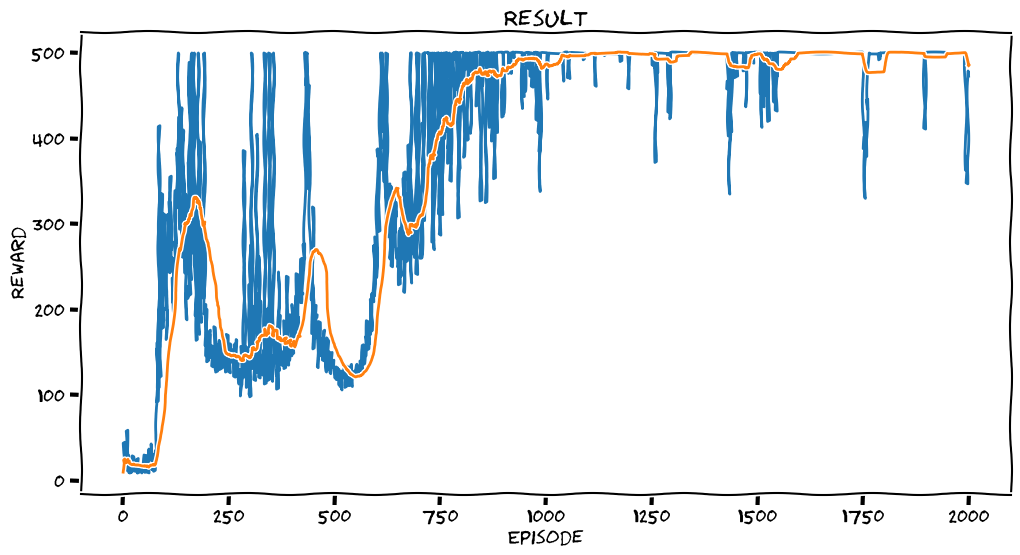

<Figure size 1200x600 with 0 Axes>

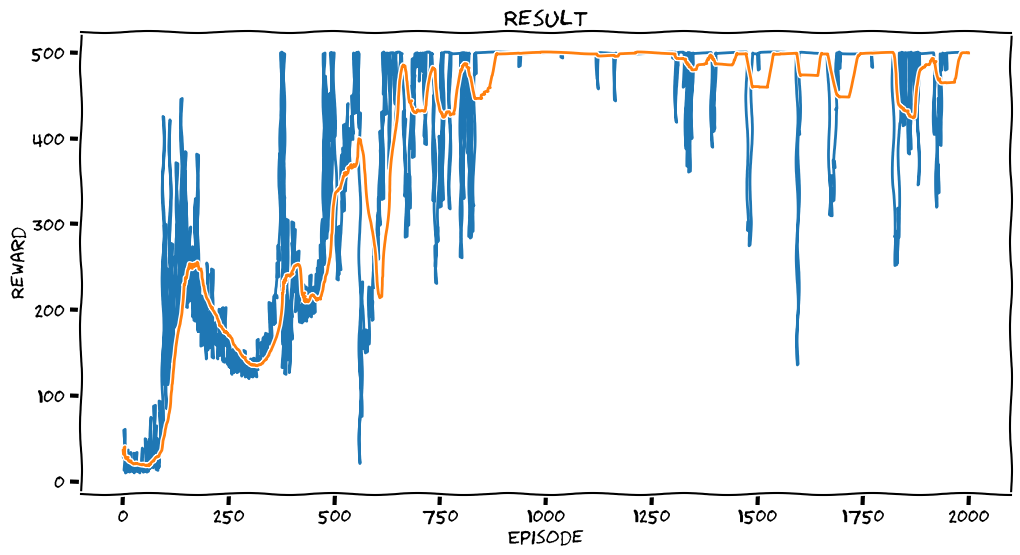

<Figure size 1200x600 with 0 Axes>

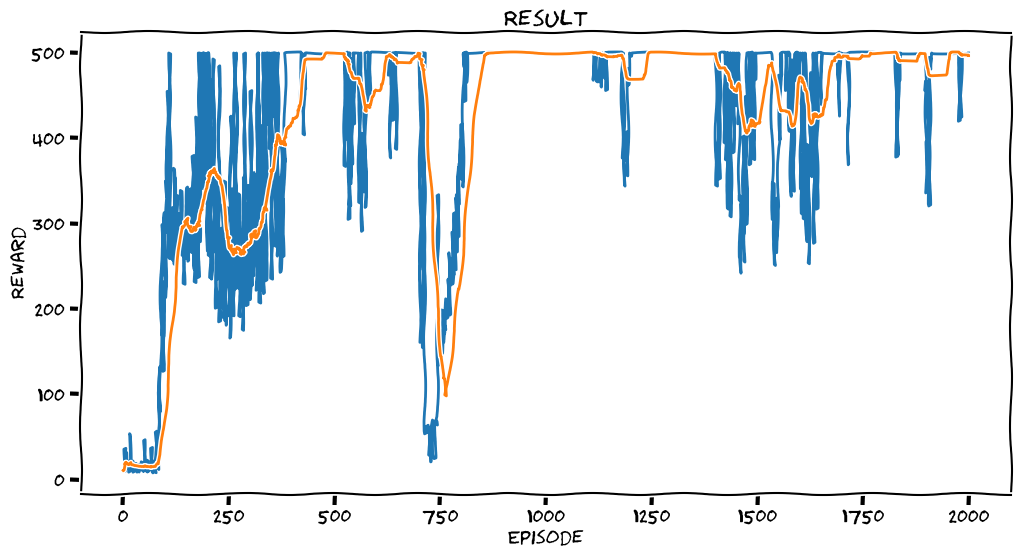

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [15]:
for i in range(len(DQN_agents)):
    progress_file = f"DQN_{i}_Network" + str(num_episodes).zfill(4)
    progress = load_progress(progress_file)  
    plot_rewards(progress, i, show_result=True)

print("+" * 50)
for i in range(len(agents)):  
    progress_file = f"DDQN_{i}_Network" + str(num_episodes).zfill(4)
    progress = load_progress(progress_file)
    plot_rewards(progress, i, show_result=True)

## **Computing the Moving Average of Results (5 points)**  

We compute a moving average to smooth the results for both DDQN and DQN across all seeds. This includes the average of the minimum, maximum, and actual returns across all seeds and episodes.  


In [16]:
def moving_average(data, window_size=25):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Compute moving averages for DDQN
DDQN_mean_rewards = moving_average(np.array(sum_of_rewards).mean(axis=0))
DDQN_min_rewards = moving_average(np.array(sum_of_rewards).min(axis=0))
DDQN_max_rewards = moving_average(np.array(sum_of_rewards).max(axis=0))

# Compute moving averages for DQN
DQN_mean_rewards = moving_average(np.array(dqn_sum_of_rewards).mean(axis=0))
DQN_min_rewards = moving_average(np.array(dqn_sum_of_rewards).min(axis=0))
DQN_max_rewards = moving_average(np.array(dqn_sum_of_rewards).max(axis=0))

## **Visualizing the Outputs (5 points)**  

Plotting the smoothed results with:  
- Lower bound as the average of minimum returns  
- Upper bound as the average of maximum returns  
- Actual moving average of the returns  

for smoother plots, you can increase the **window_size** in `moving_average` function.


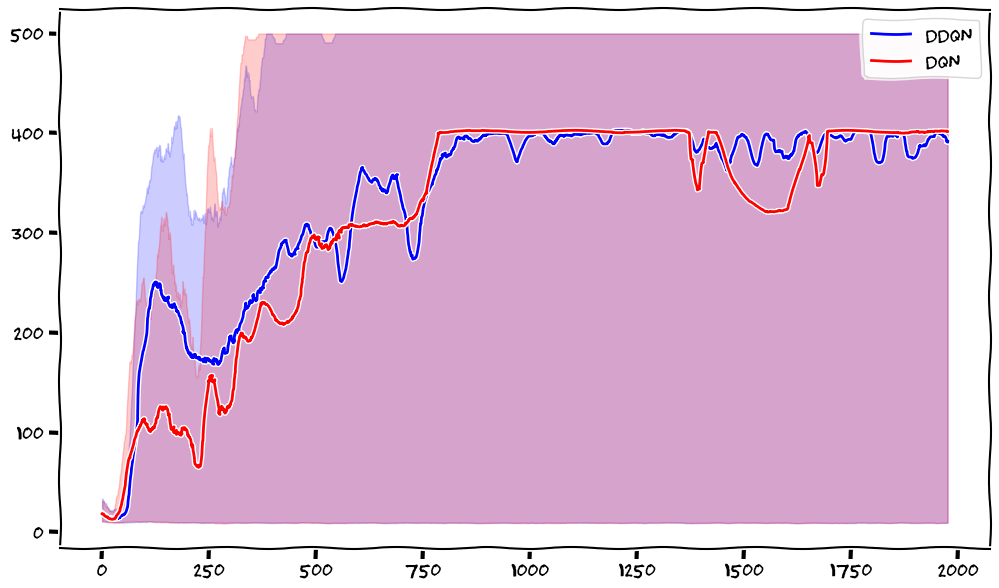

In [17]:
plot_smooth(DDQN_mean_rewards,DDQN_min_rewards,DDQN_max_rewards,DQN_mean_rewards,DQN_min_rewards,DQN_max_rewards)

## **Takeaway Questions**
- Which algorithm, DQN or DDQN, exhibits more stable learning?
    - Consider mean returns and the tightness of the upper and lower bounds in the training plot.
- Which algorithm struggles less during learning?

## **Model Evaluation (10 points)**  

To evaluate the model, we measure the **average reward** and its **standard deviation** using the following function.  


In [18]:
def evaluate_policy(env, agent, num_episodes=3):
    # Initialize list to store episode rewards
    total_rewards = []
    Episode_values = []

    for episode in range(num_episodes):
        # Reset the environment for a new episode
        state, info = env.reset()
        episode_reward = 0

        # Lists to store Q values and their running average
        values = []
        mean_value = []

        # Evaluate the agent using a greedy policy
        while True:
            # Use greedy action selection
            action, Q = agent.act(state, greedy=True)
            # Take a step in the environment
            next_state, reward, done, truncated, _ = env.step(action)

            episode_reward += reward

            # Append the Q value and compute the running mean of Q values
            values.append(Q)
            mean_value.append(np.mean(values))

            state = next_state

            # Break if the episode is terminated or truncated
            if done or truncated:
                break

        total_rewards.append(episode_reward)
        Episode_values.append(mean_value)

    # Compute the mean and standard deviation of the rewards over test episodes
    mean_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)

    return mean_reward, std_reward, Episode_values


**Run both trained policies for 3 episodes, observe the mean and std of returns, and plot the mean Q-values per episode. If the agent passes the evaluation bar, plot their mean values.**

## **Plot DDQN values**

Evaluating the 0th agent: mean_reward = 500.0 +/- 0.0

Evaluating the 1th agent: mean_reward = 9.0 +/- 0.816496580927726

Evaluating the 2th agent: mean_reward = 435.0 +/- 13.366625103842281

Evaluating the 3th agent: mean_reward = 500.0 +/- 0.0

Evaluating the 4th agent: mean_reward = 500.0 +/- 0.0



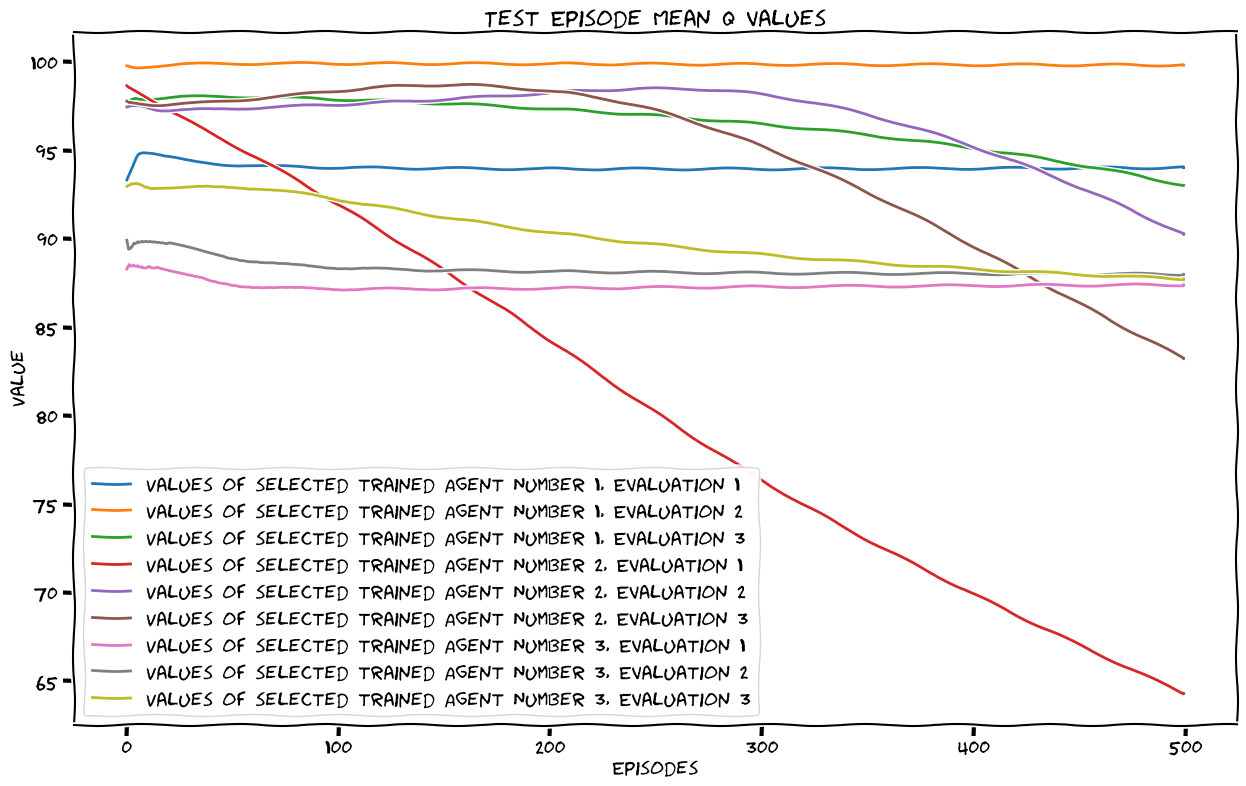

In [19]:
DDQN_values = []
# Run each trained policy for 3 episodes and observe the mean and std of received returns
# and the mean Q values over each episode
for i, DDQN_agent in enumerate(agents):
    # Evaluate the trained agent using the evaluate_policy function
    mean_reward, std_reward, mean_values = evaluate_policy(env, DDQN_agent, num_episodes=3)
    print(f"Evaluating the {i}th agent: mean_reward = {mean_reward} +/- {std_reward}\n")
    if mean_reward >= 450:
        DDQN_values.append(mean_values)

if len(DDQN_values) != 0:
    # Plot the mean Q values using the plot_values function
    plot_values(DDQN_values)
else:
    print('[Info] ... the Agent did not pass the minimum requirement. Please train it more.')


## **Plot DQN values**

Evaluating the 0th agent: mean_reward = 500.0 +/- 0.0

Evaluating the 1th agent: mean_reward = 9.666666666666666 +/- 0.4714045207910317

Evaluating the 2th agent: mean_reward = 500.0 +/- 0.0

Evaluating the 3th agent: mean_reward = 500.0 +/- 0.0

Evaluating the 4th agent: mean_reward = 500.0 +/- 0.0



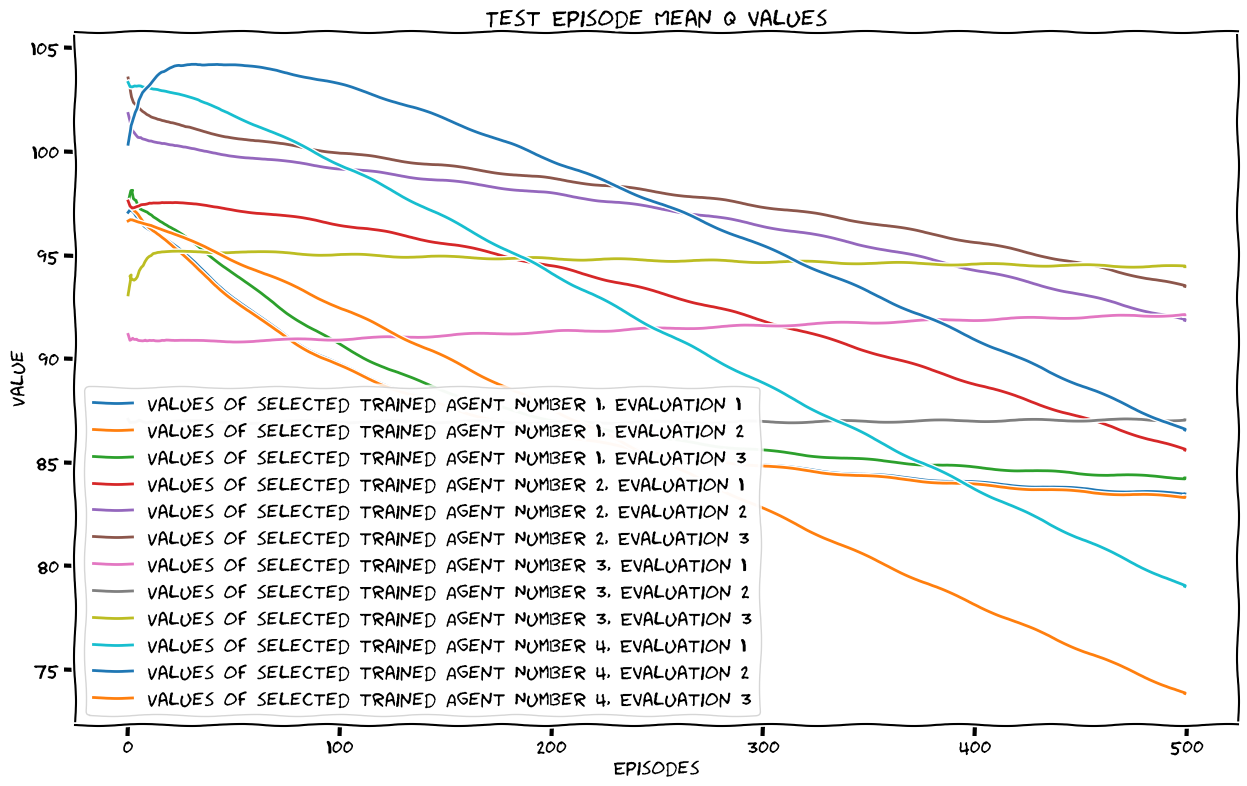

In [20]:
DQN_values = []
# Run each trained policy for 3 episodes and observe the mean and std of received returns and mean Q values over each episode
for i, DQN_agent in enumerate(DQN_agents):
    # Evaluate the trained Agent using the evaluate_policy function
    mean_reward, std_reward, mean_values = evaluate_policy(env, DQN_agent, num_episodes=3)
    print(f"Evaluating the {i}th agent: mean_reward = {mean_reward} +/- {std_reward}\n")
    if mean_reward >= 450:
        DQN_values.append(mean_values)

if len(DQN_values) != 0:
    # Plot the mean Q values using the plot_values function
    plot_values(DQN_values)
else:
    print('[Info] ... the Agent did not pass the minimum requirement. Please train it more.')


## **Watch the best Agent's performance (5 points)**
**Select one of the best agents from the evaluation step and render its performance.**

**Rendering DDQN Agent**

In [21]:
from IPython.display import display

env = gym.make("CartPole-v1", render_mode="rgb_array")
print('[info] ... rendering the DDQN Agent performance')

# Select one of the best agents based on evaluation (mean_reward >= 450)
best_agent = None
for agent in agents:
    mean_reward, _, _ = evaluate_policy(env, agent, num_episodes=3)
    if mean_reward >= 450:
        best_agent = agent
        break

if best_agent is None:
    print('[Info] No agent reached the minimum requirement for rendering. Please train it more.')
else:
    # Render the performance as a video using the provided helper function
    video = create_policy_eval_video(env, best_agent, filename="DDQN_best_agent", num_episodes=1, fps=30)
    display(video)


[info] ... rendering the DDQN Agent performance


**Rendering DQN Agent**

In [22]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
print('[info] ... rendering the DQN Agent performance')

# Select one of the best agents based on evaluation (mean_reward >= 450)
best_agent = None
for agent in DQN_agents:
    mean_reward, _, _ = evaluate_policy(env, agent, num_episodes=3)
    if mean_reward >= 450:
        best_agent = agent
        break

if best_agent is None:
    print('[Info] No DQN agent reached the minimum requirement for rendering. Please train it more.')
else:
    # Render the performance as a video using the provided helper function
    video = create_policy_eval_video(env, best_agent, filename="DQN_best_agent", num_episodes=1, fps=30)
    display(video)


[info] ... rendering the DQN Agent performance


## **Takeaway Questions**
- Which agent is trained better considering the evaluation and rendering the performance?
- One of the DDQN's goal is to prevent Q values over estimation. Did you observe this phenomenon after ploting the Mean Q values and comparing them to DQN values?